In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import warnings


In [2]:
crashes = pd.read_csv("crashesClean.csv")
cameras = pd.read_csv("Automated_Traffic_Enforcement_Table.csv")

In [3]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303606 non-null  object 
 1   LATITUDE              303606 non-null  float64
 2   LONGITUDE             303606 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303606 non-null  int64  
 5   TOTAL_BICYCLES        303606 non-null  int64  
 6   TOTAL_PEDESTRIANS     303606 non-null  int64  
 7   NEARESTINTSTREETNAME  303606 non-null  object 
 8   OFFINTERSECTION       303606 non-null  float64
 9   crash_datetime        303606 non-null  object 
 10  year                  303606 non-null  int64  
 11  month                 303606 non-null  int64  
 12  weekday               303606 non-null  object 
 13  fatalities            303606 non-null  float64
 14  majorinjuries         303606 non-null  float64
 15  

In [4]:
cameras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ENFORCEMENT_SPACE_CODE  719 non-null    object 
 1   LOCATION_DESCRIPTION    554 non-null    object 
 2   SITE_CODE               554 non-null    float64
 3   ACTIVE_STATUS           719 non-null    object 
 4   CAMERA_STATUS           719 non-null    object 
 5   START_DATE              554 non-null    object 
 6   END_DATE                0 non-null      float64
 7   DEVICE_MOBILITY         96 non-null     object 
 8   ENFORCEMENT_TYPE        718 non-null    object 
 9   SPEED_LIMIT             485 non-null    float64
 10  CAMERA_LATITUDE         313 non-null    float64
 11  CAMERA_LONGITUDE        313 non-null    float64
 12  CAMERA_EASTING          313 non-null    float64
 13  CAMERA_NORTHING         313 non-null    float64
 14  OBJECTID                719 non-null    in

In [5]:
# Focus on Crashes within: Ward 2, Ward 5, Ward 6
crashesFA = crashes[crashes['WARD'].isin(['Ward 2', 'Ward 5', 'Ward 6'])]

print("% of Crashes in Focus Areas (Wards 2, 5, 6)\n",len(crashesFA) / len(crashes) * 100)

% of Crashes in Focus Areas (Wards 2, 5, 6)
 50.7121071388576


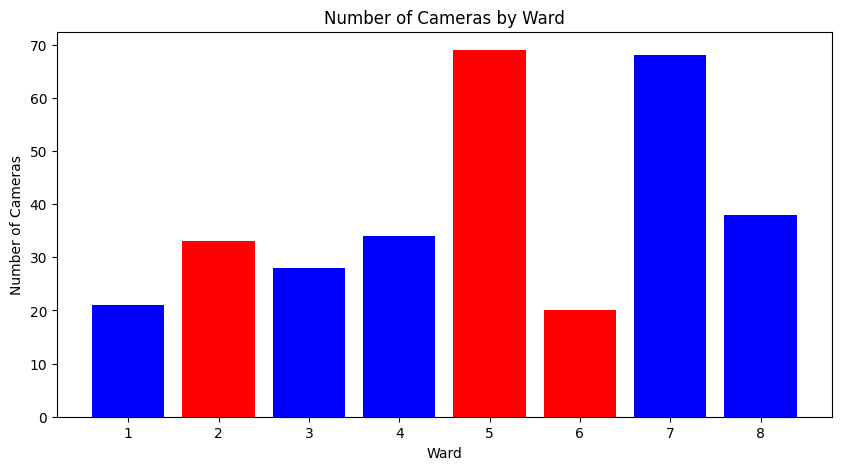

In [6]:
# Remove 'END_DATE' & 'DEVICE_MOBILITY' columns
cameras.drop(['END_DATE', 'DEVICE_MOBILITY'], axis=1, inplace=True)

# Show number of Cameras by Ward 
ward_counts = cameras["WARD"].value_counts()

# Ensure correct ward order 1–8
wards = [1, 2, 3, 4, 5, 6, 7, 8]
counts_ordered = [ward_counts.get(w, 0) for w in wards]

# Highlight wards 2, 5, and 6 in red
colors = ['red' if w in [2, 5, 6] else 'blue' for w in wards]

plt.figure(figsize=(10,5))
plt.bar(wards, counts_ordered, color=colors)

plt.xlabel("Ward")
plt.ylabel("Number of Cameras")
plt.title("Number of Cameras by Ward")
plt.xticks(wards)

plt.show()


In [7]:
# Keep only the columns we need
crashes_small = crashesFA[['LATITUDE', 'LONGITUDE']].copy()
cameras_small = cameras[['CAMERA_LATITUDE', 'CAMERA_LONGITUDE', 'WARD']].copy()

# Drop NaN or inf values
crashes_small = crashes_small.dropna(subset=['LATITUDE', 'LONGITUDE'])
crashes_small = crashes_small[np.isfinite(crashes_small['LATITUDE'])]
crashes_small = crashes_small[np.isfinite(crashes_small['LONGITUDE'])]

cameras_small = cameras_small.dropna(subset=['CAMERA_LATITUDE', 'CAMERA_LONGITUDE'])
cameras_small = cameras_small[np.isfinite(cameras_small['CAMERA_LATITUDE'])]
cameras_small = cameras_small[np.isfinite(cameras_small['CAMERA_LONGITUDE'])]

# Optional: downcast floats to float32 for speed
crashes_small['LATITUDE'] = crashes_small['LATITUDE'].astype('float32')
crashes_small['LONGITUDE'] = crashes_small['LONGITUDE'].astype('float32')
cameras_small['CAMERA_LATITUDE'] = cameras_small['CAMERA_LATITUDE'].astype('float32')
cameras_small['CAMERA_LONGITUDE'] = cameras_small['CAMERA_LONGITUDE'].astype('float32')


In [5]:
cameras_small.head()
    

NameError: name 'cameras_small' is not defined

In [9]:
### Set colors for each ward
ward_colors = {
    'Ward 2': 'red',
    'Ward 5': 'green',
    'Ward 6': 'blue'
}
# Filter crashes
crash_w = crashesFA[crashesFA['WARD'].isin(ward_colors.keys())].copy()
crash_w = crash_w.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Filter cameras
cam = cameras_small.dropna(subset=['CAMERA_LATITUDE', 'CAMERA_LONGITUDE'])

# Create center point to center maps on 
center_lat = float(crash_w['LATITUDE'].mean())
center_lon = float(crash_w['LONGITUDE'].mean())

In [11]:
warnings.filterwarnings("ignore")
# Load & filter crashes
df = pd.read_csv("crashesClean.csv")
df = df[df['WARD'].isin(['Ward 2', 'Ward 5', 'Ward 6'])]
df = df.rename(columns={"LATITUDE": "lat", "LONGITUDE": "lon"})
df['year'] = pd.to_datetime(df['crash_datetime']).dt.year

# Map ward to color
ward_colors = {'Ward 2': 'red', 'Ward 5': 'green', 'Ward 6': 'blue'}

# Prepare cameras
camerasF = cameras_small[cameras_small['WARD'].isin([2.0, 5.0, 6.0])]
camerasF = camerasF.rename(columns={"CAMERA_LATITUDE": "lat", "CAMERA_LONGITUDE": "lon"})

# Update function
def update_map(wards, years, mode):
    data = df[df['WARD'].isin(wards) & df['year'].isin(years)]

    if 'Fatalities only' in mode:
        data = data[data['fatalities'] > 0]

    if data.empty:
        print("No data for this selection")
        return

    # --- Base figure ---
    fig = go.Figure()

    # Add one trace per ward
    for ward, color in ward_colors.items():
        ward_data = data[data['WARD'] == ward]
        if not ward_data.empty:
            fig.add_trace(
                go.Scattermapbox(
                    lat=ward_data['lat'],
                    lon=ward_data['lon'],
                    mode='markers',
                    marker=dict(size=6, color=color),
                    name=f"Crashes {ward}"
                )
            )

    # Overlay cameras as black borders
    fig.add_trace(
        go.Scattermapbox(
            lat=camerasF['lat'],
            lon=camerasF['lon'],
            mode='markers',
            marker=dict(size=12, color='black'),
            name="Cameras border"
        )
    )

    # Overlay cameras as white circles on top
    fig.add_trace(
        go.Scattermapbox(
            lat=camerasF['lat'],
            lon=camerasF['lon'],
            mode='markers',
            marker=dict(size=8, color='white'),
            name="Cameras"
        )
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": 38.8951, "lon": -77.0364},  # center on DC
        mapbox_zoom=11,
        margin={"r":0,"t":0,"l":0,"b":0},
        height=800
    )

    fig.show()

# Widgets
ward_selector = widgets.SelectMultiple(
    options=['Ward 2', 'Ward 5', 'Ward 6'],
    value=['Ward 2', 'Ward 5', 'Ward 6'],
    description="Wards:",
    layout=widgets.Layout(width='auto')
)

year_selector = widgets.SelectMultiple(
    options=sorted(df['year'].unique()),
    value=[df['year'].max()],
    description="Years:"
)

mode_toggle = widgets.SelectMultiple(
    options=["All crashes", "Fatalities only"],
    value=["All crashes"],
    description="Filter:"
)

# Horizontal layout
ui = widgets.HBox([ward_selector, year_selector, mode_toggle])

out = widgets.interactive_output(
    update_map,
    {"wards": ward_selector, "years": year_selector, "mode": mode_toggle}
)

display(ui, out)


Output()

In [12]:
### Hexbin of Crashes by Ward
# Suppress warnings
warnings.filterwarnings("ignore")

# Load & filter crashes
df2 = pd.read_csv("crashesClean.csv")
df2 = df2[df2['WARD'].isin(['Ward 2', 'Ward 5', 'Ward 6'])]
df2 = df2.rename(columns={"LATITUDE": "lat", "LONGITUDE": "lon"})
df2['year'] = pd.to_datetime(df2['crash_datetime']).dt.year

ward_colors = {'Ward 2': 'red', 'Ward 5': 'green', 'Ward 6': 'blue'}

# Prepare cameras
camerasF2 = cameras_small[cameras_small['WARD'].isin([2.0, 5.0, 6.0])]
camerasF2 = camerasF2.rename(columns={"CAMERA_LATITUDE": "lat", "CAMERA_LONGITUDE": "lon"})

# Hexbin function
def hexbin_density(df, x_col='lon', y_col='lat', gridsize=50):
    """Convert points to 2D hexbin densities."""
    hb = plt.hexbin(df[x_col], df[y_col], gridsize=gridsize)
    counts = hb.get_array()
    verts = hb.get_offsets()
    plt.close()
    hex_df = pd.DataFrame(verts, columns=['lon', 'lat'])
    hex_df['count'] = counts
    return hex_df

# Update function
def update_map(wards, years, mode):
    data = df2[df2['WARD'].isin(wards) & df2['year'].isin(years)]

    if 'Fatalities only' in mode:
        data = data[data['fatalities'] > 0]

    if data.empty:
        print("No data for this selection")
        return

    fig = go.Figure()

    # --- Smooth hexbin density per ward ---
    for ward, color in ward_colors.items():
        ward_data = data[data['WARD'] == ward]
        if not ward_data.empty:
            hex_df = hexbin_density(ward_data, gridsize=50)
            fig.add_trace(
                go.Scattermapbox(
                    lat=hex_df['lat'],
                    lon=hex_df['lon'],
                    mode='markers',
                    marker=dict(
                        size=hex_df['count']*2,
                        color=color,
                        opacity=0.4,
                        sizemode='area'
                    ),
                    name=f"Crashes {ward}"
                )
            )

    # --- Overlay cameras with white circle + black border ---
    # 1. Black border
    fig.add_trace(
        go.Scattermapbox(
            lat=camerasF2['lat'],
            lon=camerasF2['lon'],
            mode='markers',
            marker=dict(size=12, color='black'),
            name="Cameras border"
        )
    )
    # 2. White circle
    fig.add_trace(
        go.Scattermapbox(
            lat=camerasF2['lat'],
            lon=camerasF2['lon'],
            mode='markers',
            marker=dict(size=8, color='white'),
            name="Cameras"
        )
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": 38.8951, "lon": -77.0364},  # center on DC
        mapbox_zoom=11,
        autosize=True,
        height=900,  # increased height to prevent cutting off
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    fig.show()

# Widgets
ward_selector = widgets.SelectMultiple(
    options=['Ward 2', 'Ward 5', 'Ward 6'],
    value=['Ward 2', 'Ward 5', 'Ward 6'],
    description="Wards:",
    layout=widgets.Layout(width='auto')
)

year_selector = widgets.SelectMultiple(
    options=sorted(df2['year'].unique()),
    value=[df2['year'].max()],
    description="Years:"
)

mode_toggle = widgets.SelectMultiple(
    options=["All crashes", "Fatalities only"],
    value=["All crashes"],
    description="Filter:"
)

ui = widgets.HBox([ward_selector, year_selector, mode_toggle])

out = widgets.interactive_output(
    update_map,
    {"wards": ward_selector, "years": year_selector, "mode": mode_toggle}
)

display(ui, out)


Output()